In [1]:
!nvidia-smi

Thu Jul 31 17:08:48 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.127.05             Driver Version: 550.127.05     CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA RTX 6000 Ada Gene...    On  |   00000000:81:00.0 Off |                  Off |
| 30%   37C    P3             39W /  300W |       2MiB /  49140MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import csv
import json

from datetime import datetime

import matplotlib.pyplot as plt

import numpy as np

import os

import os.path as osp 

import pandas as pd
from pprint import pprint

import re

import sys
sys.path.append("../")

from tqdm.auto import tqdm
import torch
import torch.nn as nn

from typing import Tuple, Any

from transformers import GenerationConfig

In [4]:
from src.__init__ import logger
from src.config import Config
from src.model import ARCModel
from src.utils import (load_data, 
                        sample_arc_task, 
                        visualize_task, 
                        grid_to_text, 
                        text_to_grid, 
                        infer_out_shape,
                        get_row_sizes,
                        reconstruct_grids,
                        get_grid_shape)

In [5]:
base_prompt_path = "../src/base_prompt.txt"

with open(base_prompt_path, "r") as f:
    base_prompt = f.read().strip()

#pprint(base_prompt)
prompt = "How would you solve such puzzles to ensure the highest accuracy?"

In [6]:
train_data, test_data = load_data(data_path=Config.data_path)

print(f"✓ Loaded {len(train_data)} training problems")

✓ Loaded 746 training problems


# Try out LLM

In [7]:
model = ARCModel(
    system_prompt_path=base_prompt_path, 
    verbose=False,
    target_platform=Config.target_platform
)

Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

[INFO] ✅ Successfully loaded base LLM (Qwen/Qwen2.5-14B-Instruct).


## Run generation

In [8]:
messages = [
    {"role": "system","content": model.base_prompt},
    {"role": "user", "content": prompt}
]

inputs = model.tokenizer.apply_chat_template(
    messages,
    tokenize=False if Config.target_platform=="mlx" else True,
    add_generation_prompt=True,
    return_tensors="pt",
    return_dict=True
)
if Config.target_platform!="mlx":
    inputs = {k: v.to(Config.device) for k, v in inputs.items() if k!="token_type_ids"}

inputs.keys()

dict_keys(['input_ids', 'attention_mask'])

In [11]:
generation_config = GenerationConfig(
    max_new_tokens=Config.max_tokens,
    temperature=Config.temperature,
    top_p=Config.top_p,
    do_sample=Config.do_sample,
    verbose=True,
    pad_token_id=model.tokenizer.eos_token_id if model.tokenizer else None,
    repetition_penalty=Config.repetition_penalty
)

generation_config

GenerationConfig {
  "do_sample": true,
  "max_new_tokens": 4096,
  "pad_token_id": 151645,
  "repetition_penalty": 1.2,
  "temperature": 0.15,
  "top_p": 0.95,
  "verbose": true
}

In [12]:
%%time

with torch.no_grad():
    response = model.llm.generate(
        **inputs,
        generation_config=generation_config,
    )        
    response = model.tokenizer.batch_decode(response[:, inputs["input_ids"].shape[-1]:])

CPU times: user 25.8 s, sys: 729 ms, total: 26.6 s
Wall time: 27.5 s


In [13]:
print("".join(response))

Solving Abstraction and Reasoning Corpus (ARC) puzzles accurately involves several key steps that help identify and apply the correct transformation rule:

### Step-by-step Guide

#### 1. **Analyze Training Examples**
   - Carefully examine all provided pairs of input and output grids for any consistent patterns or differences between them.

#### 2. **Identify Common Shapes/Patterns**
   - Look out for recurring structures like squares, rectangles, "L" shapes, "T" shapes, cross-shaped regions, etc.
   - Note if certain areas remain unchanged while others transform predictably into different forms/shades/colors.

#### 3. **Pattern Recognition & Transformation Logic**
   - Determine what kind of change occurs within identified regions—do they get resized, rotated, flipped horizontally/vertically, colored differently, split up, merged together, repeated elsewhere?

#### 4. **Test Hypotheses Against More Data Points**
   - Apply your inferred rules back onto other given inputs/output pairs

## Solve Sample Task

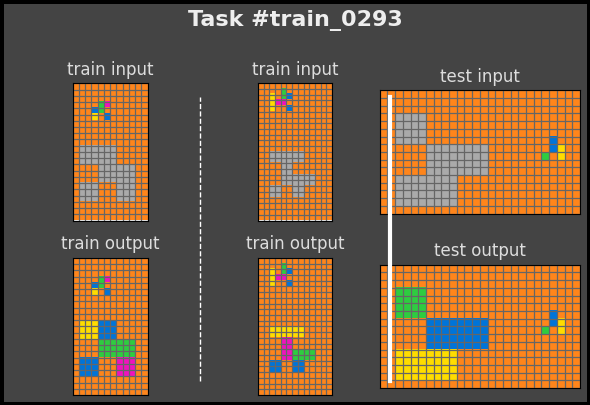

In [18]:
task_id, task = sample_arc_task(train_data, split=None)

test_output = task["test"][0]["output"] if "output" in task["test"][0].keys() else None

visualize_task(
    task_data=task,
    task_id=task_id, 
    size=2.0, 
    w1=.9
)

In [19]:
%%time 

expected_shape = get_grid_shape(test_output)

response, out = model.solve_with_llm(
    task=task, 
    expected_shape=expected_shape,
    verbose=True
)

[INFO] Preparing inputs
[INFO] Done!
[INFO] Prompting LLM...
[INFO] Done
[INFO] Completion time: 51.9977 seconds
[[7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7],
[7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7],
[7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7],
[7, 7, 3, 3, 3, 3, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7],
[7, 7, 3, 3, 3, 3, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7],
[7, 7, 3, 3, 3, 3, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7],
[7, 7, 3, 3, 3, 3, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 1, 7, 4, 7, 7],
[7, 7, 7, 7, 7, 7, 3, 3, 3, 3, 3, 3, 3, 3, 7, 7, 7, 7, 7, 7, 7, 7, 1, 6, 7, 7],
[7, 7, 7, 7, 7, 7, 3, 3, 3, 3, 3, 3, 3, 3, 7, 7, 7, 7, 7, 7, 7, 7, 1, 6, 7, 7],
[7, 7, 7, 7, 7, 7, 3, 3, 3, 3, 3, 3, 3, 3, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7],
[7, 7, 7, 7, 7, 7, 3, 3, 3, 3, 3, 3, 3, 3, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7],
[7, 7,

In [20]:
get_grid_shape(task["test"][0]["output"]) == get_grid_shape(out)

True

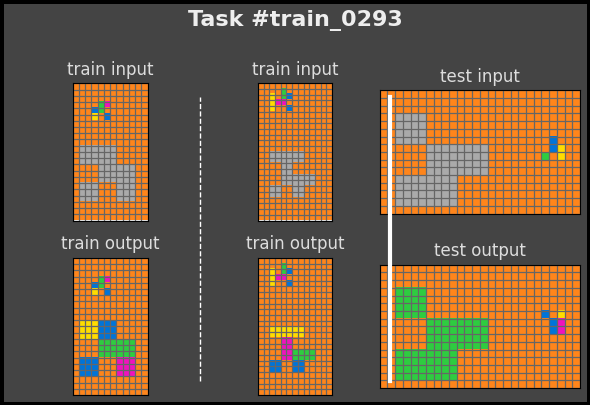

In [21]:
solution = {
    f"{task_id}": out
}

visualize_task(
    task_data=task,
    task_id=task_id, 
    size=2.0, 
    w1=.9,
    task_solutions=solution
)

# Batch Solving

In [8]:
total_match = 0
total_pix_acc = 0
train_preds = []
N = 10

expected_shape = None

for _ in range(N):
    task_id, task = sample_arc_task(train_data, split=None)        
    test_output = task["test"][0]["output"] if "output" in task["test"][0].keys() else None

    if test_output is not None:
        expected_shape = get_grid_shape(test_output)
    
    _, pred = model.solve_with_llm(
        task=task, 
        task_id=task_id,
        verbose=True
    )  

    solution = {
        f"{task_id}": pred
    }
    
    train_preds.append(solution)

    metrics = model.evaluate(task, [pred])
    match, pix_acc = metrics.values()
        
    total_match+=match
    total_pix_acc+=pix_acc

    print()

avg_acc = total_match/N
avg_pix_acc = total_pix_acc/N

print(f"{avg_acc*100:.5f}% correct matches with {avg_pix_acc*100:.5f}% pixel acc")

[INFO] task_id='train_0375'
[INFO] Input shape: 		(19, 27)
[INFO] Inferred output shape: 	(19, 27)
[INFO] Prompting LLM...
[INFO] Done!
[INFO] Task train_0375 -- Completion time: 47.3588 seconds

[INFO] task_id='train_0522'
[INFO] Input shape: 		(22, 25)
[INFO] Inferred output shape: 	(22, 25)
[INFO] Prompting LLM...
[INFO] Done!
[INFO] Task train_0522 -- Completion time: 63.8394 seconds

[INFO] task_id='train_0341'
[INFO] Input shape: 		(16, 16)
[INFO] Inferred output shape: 	(16, 16)
[INFO] Prompting LLM...
[INFO] Done!
[INFO] Task train_0341 -- Completion time: 32.6177 seconds

[INFO] task_id='train_0633'
[INFO] Input shape: 		(20, 20)
[INFO] Inferred output shape: 	(3, 3)
[INFO] Prompting LLM...
[INFO] Done!
[INFO] Task train_0633 -- Completion time: 2.8440 seconds

[INFO] task_id='train_0103'
[INFO] Input shape: 		(10, 10)
[INFO] Inferred output shape: 	(10, 10)
[INFO] Prompting LLM...
[INFO] Done!
[INFO] Task train_0103 -- Completion time: 12.5357 seconds

[INFO] task_id='train_0

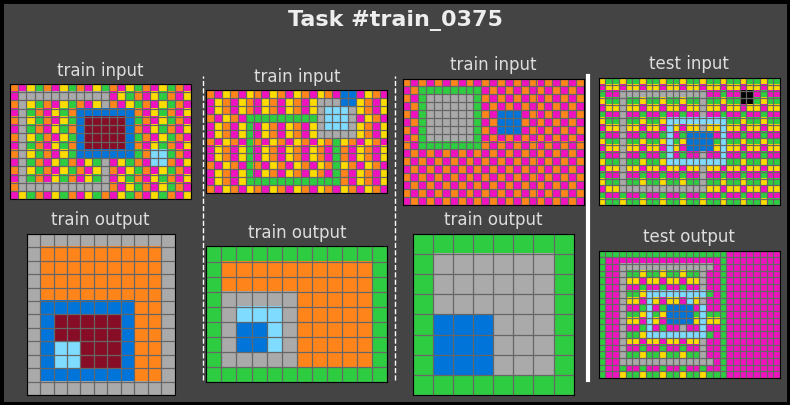

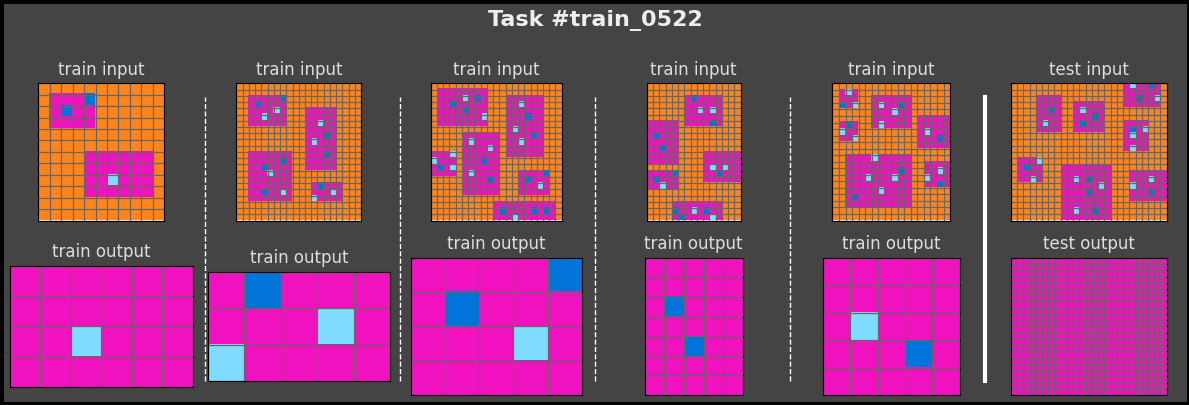

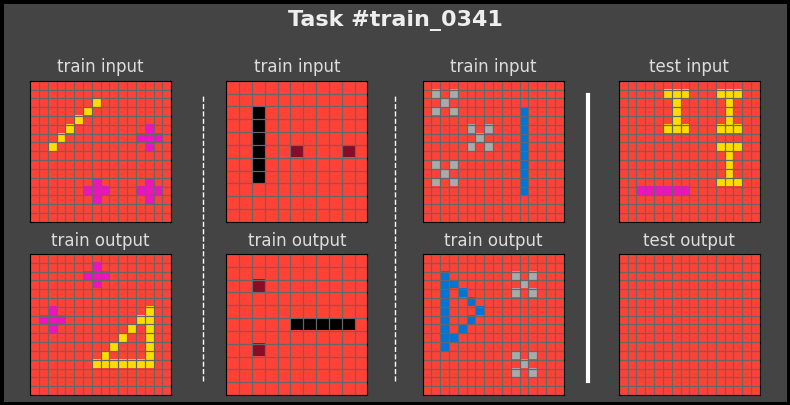

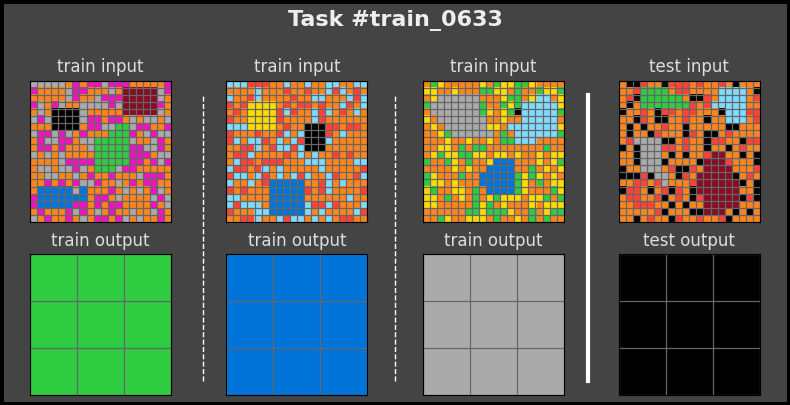

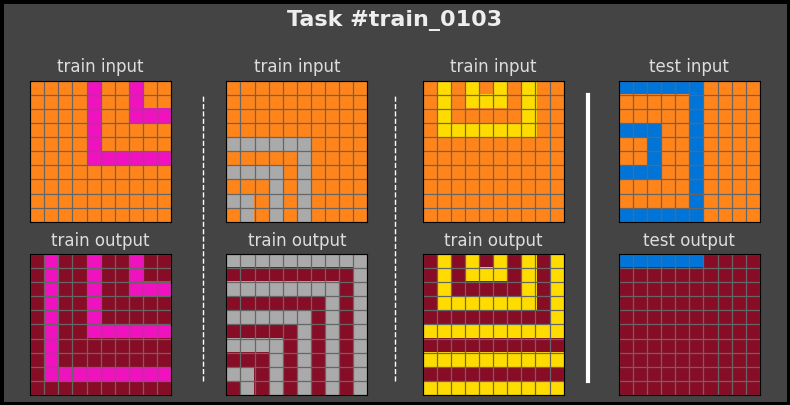

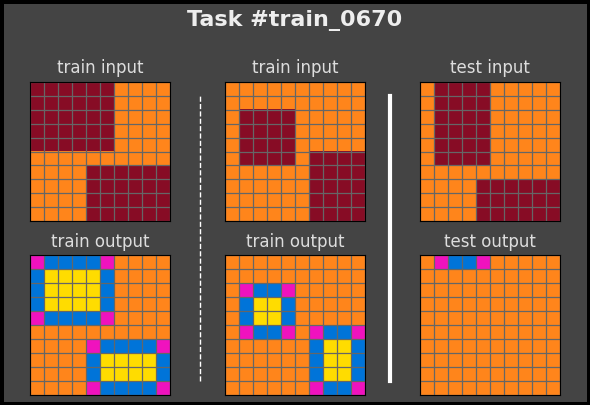

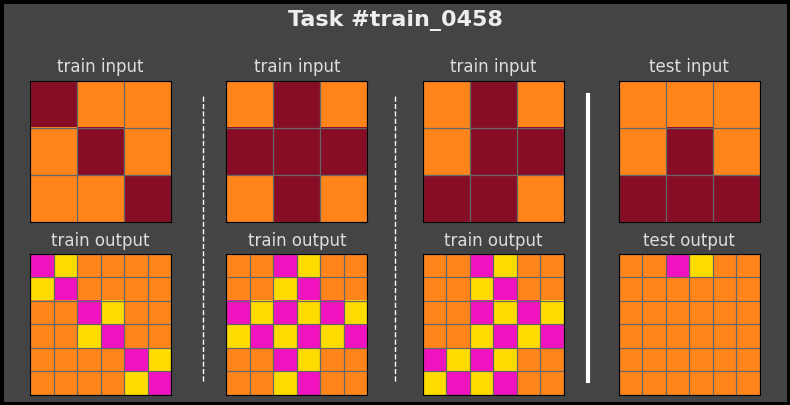

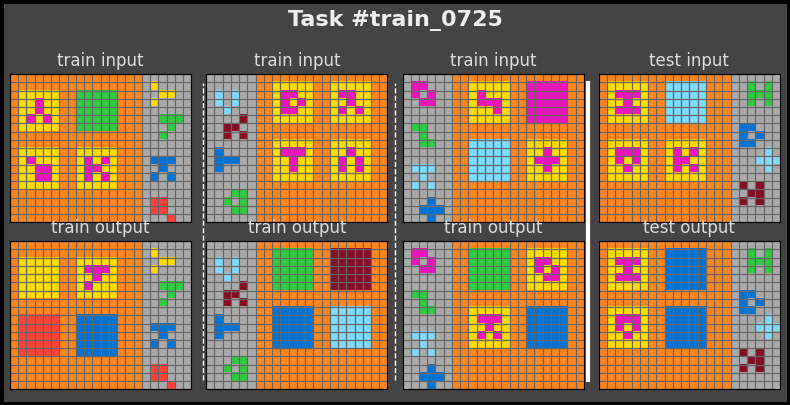

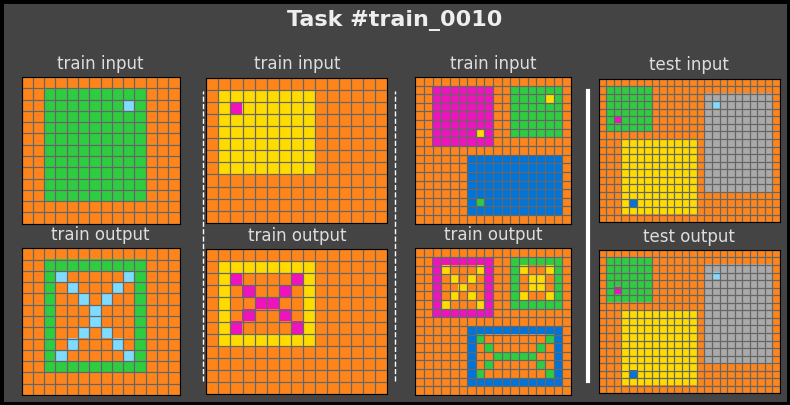

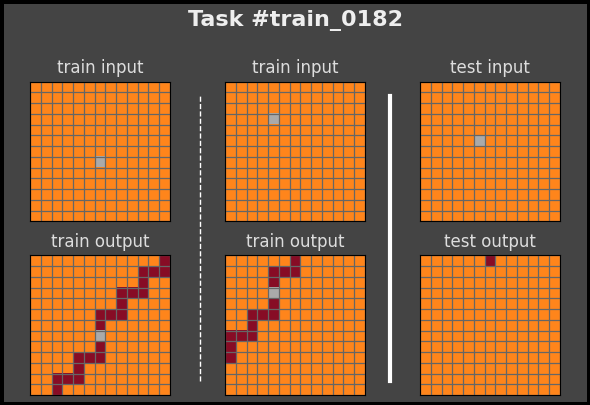

In [9]:
for solution in train_preds:
    task_id = list(solution.keys())[0]
    task = train_data[task_id]
    
    visualize_task(
        task_data=task,
        task_id=task_id, 
        size=2.0, 
        w1=.9,
        task_solutions=solution
    )

# Predict on Test Set

In [10]:
# Load sample submission to see the format
ss = pd.read_csv(
    osp.join(Config.data_path, 'SampleSubmission.csv'),
    dtype={"row": str}
)

print(f"✓ Sample submission has {len(ss)} predictions")

✓ Sample submission has 2303 predictions


In [11]:
test_out_rows = get_row_sizes(ss)

In [12]:
test_out_rows.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
n_rows,185.0,12.448649,7.509328,1.0,8.0,10.0,16.0,30.0


In [13]:
# Sort by 
test_out_rows_sorted = test_out_rows.sort_values(by="n_rows", ascending=True)
test_out_rows_sorted

,ID_,n_rows
169,test_0169,1
135,test_0135,1
54,test_0054,2
123,test_0123,2
108,test_0108,2
...,...,...
4,test_0004,30
83,test_0083,30
150,test_0150,30
167,test_0167,30


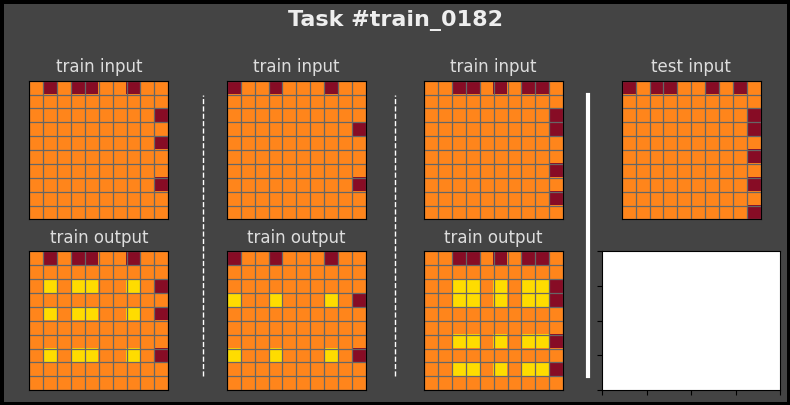

In [14]:
test_case = "test_0002"
n_out_rows = test_out_rows.loc[test_out_rows["ID_"] == test_case, "n_rows"].item()
task = test_data[test_case]

visualize_task(
    task_data=task,
    task_id=task_id, 
    size=2.0, 
    w1=.9
)

In [15]:
%%time 

response, pred = model.solve_with_llm(
    task=task, 
    task_id=task_id,
    verbose=True
) 

[INFO] Input shape: 		(10, 10)
[INFO] Inferred output shape: 	(10, 10)
[INFO] Prompting LLM...
[INFO] Done!
[INFO] Task train_0182 -- Completion time: 12.4378 seconds
CPU times: user 12.3 s, sys: 393 ms, total: 12.7 s
Wall time: 12.7 s


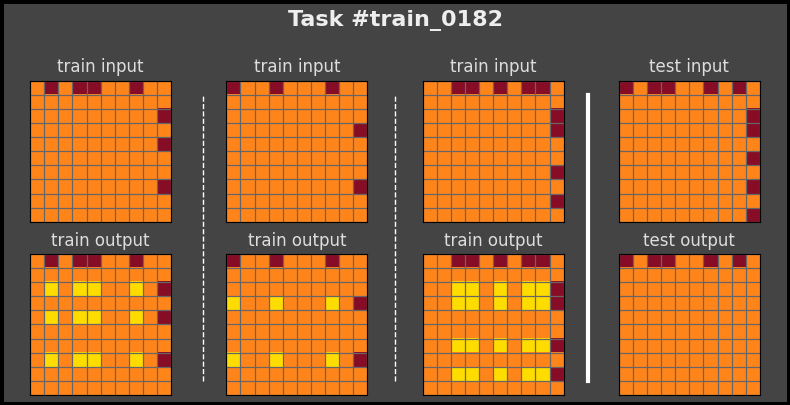

In [16]:
solution = {
    f"{task_id}": pred
}

visualize_task(
    task_data=task,
    task_id=task_id, 
    size=2.0, 
    w1=.9,
    task_solutions=solution
)

value_counts = test_out_rows["n_rows"].value_counts()

value_counts.plot(kind="bar", figsize=(8, 4))
plt.xlabel("# out rows")
plt.ylabel("Count")
plt.title("Value Counts in 'n_rows'")
plt.tight_layout()
plt.show()

In [18]:
%%time

save_path = "../submissions/predictions.json"

# Load existing results if resuming
if os.path.exists(save_path):
    with open(save_path, "r") as f:
        all_preds = json.load(f)
else:
    all_preds = {}

test_preds = []

for idx, row in tqdm(test_out_rows_sorted.iterrows(), total=len(test_out_rows_sorted)):    
    task_id = row.ID_
    task = test_data[task_id]

    # Skip already-computed
    if task_id in all_preds:
        continue

    _, pred = model.solve_with_llm(
        task=task, 
        task_id=task_id,
        verbose=False
    )  

    # Store output
    all_preds[task_id] = {"output": pred}

    # append to summary lists
    test_preds.append(pred)

    # Save to JSON incrementally
    with open(save_path, "w") as f:
        json.dump(all_preds, f)

  0%|          | 0/185 [00:00<?, ?it/s]

[INFO] Task test_0169 -- Completion time: 2.2615 seconds
[INFO] Task test_0135 -- Completion time: 0.3773 seconds
[INFO] Task test_0054 -- Completion time: 0.8527 seconds
[INFO] Task test_0123 -- Completion time: 0.7720 seconds
[INFO] Task test_0108 -- Completion time: 1.6149 seconds
[INFO] Task test_0143 -- Completion time: 1.4611 seconds
[INFO] Task test_0034 -- Completion time: 1.6075 seconds
[INFO] Task test_0011 -- Completion time: 4.1305 seconds
[INFO] Task test_0042 -- Completion time: 3.4893 seconds
[INFO] Task test_0061 -- Completion time: 2.4126 seconds
[INFO] Task test_0057 -- Completion time: 1.6918 seconds
[INFO] Task test_0124 -- Completion time: 1.5280 seconds
[INFO] Task test_0068 -- Completion time: 2.8539 seconds
[INFO] Task test_0044 -- Completion time: 1.3206 seconds
[INFO] Task test_0060 -- Completion time: 1.3155 seconds
[INFO] Task test_0017 -- Completion time: 1.0785 seconds
[INFO] Task test_0118 -- Completion time: 6.3315 seconds
[INFO] Task test_0075 -- Comple

# Submission

In [19]:
def sort_K(id_str):
    match = re.match(r"(.*)_(\d+)$", id_str)
    if match:
        task_id, row_num = match.groups()
        return (task_id, int(row_num))
    return (id_str, 0)  # fallback

def generate_submission(
    test_data,
    predictions, 
    expected_rows_list: pd.DataFrame, 
    output_path="submission.csv",
    fill_value=Config.DEFAULT_BG_VALUE
):
    """
    Generates a CSV submission file by solving all test tasks.
    Pads missing rows and sorts by ID before saving.
    """
    assert len(predictions) == len(expected_rows_list), "Mismatch between tasks and expected row counts"

    submission_rows = []
    test_keys = expected_rows_list.ID_.tolist()

    for idx, task_id in enumerate(test_keys):
        expected_rows = expected_rows_list.n_rows.iloc[idx]
        pred = predictions[idx]

        n_cols = len(pred[0]) if pred else expected_rows  # avoid crash on empty predictions

        # Pad missing rows if needed
        while len(pred) < expected_rows:
            pred.append([fill_value] * n_cols)

        # Add to submission
        for row_idx, row in enumerate(pred):
            row_str = "".join(str(cell) for cell in row)
            submission_rows.append((f"{task_id}_{row_idx+1}", row_str))

    # Sort by ID (lexical order)
    submission_rows.sort(key=lambda x: sort_K(x[0]))

    # Write to CSV
    with open(output_path, "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(["ID", "row"])
        writer.writerows(submission_rows)

    print(f"Submission saved to {output_path}")



def generate_submission(
    test_data,
    model,
    expected_rows_list:pd.DataFrame,
    output_path="submission.csv",
    intermediate_json_path=None,
    skip_completed=True,
    verbose=False,
):
    """
    Generates a CSV submission file by solving all test tasks with the provided model.
    
    Args:
        test_data: dict of test_xxx: [{train: ..., test: ...}]
        model: ARCModel with a solve_with_llm method
        expected_rows_list: list of expected row counts aligned with test_data keys
        output_path: path to final CSV submission
        intermediate_json_path: optional path to save intermediate predictions as JSON
        skip_completed: if True, will skip tasks already in intermediate JSON
        verbose: if True, will print solve logs
    """
    assert len(test_data) == len(expected_rows_list), "Mismatch between test set and expected row count list"

    submission_rows = []
    predictions = {}
    completion_times = []

    # Load intermediate progress
    if intermediate_json_path and os.path.exists(intermediate_json_path):
        with open(intermediate_json_path, "r") as f:
            predictions = json.load(f)

    for idx, row in tqdm(expected_rows_list.iterrows(), total=len(expected_rows_list)):    
        task_id = row.ID_
        task = test_data[task_id]        
    
        if skip_completed and task_id in predictions:
            continue

        task = test_data[task_id]
        expected_rows = expected_rows_list[idx]

        _, pred, completion_time = model.solve_with_llm(
            task=task,
            expected_rows=expected_rows,
            verbose=verbose,
        )

        predictions[task_id] = {"output": pred}
        completion_times.append(completion_time)

        # Save intermediate JSON
        if intermediate_json_path:
            with open(intermediate_json_path, "w") as f:
                json.dump(predictions, f)

    # Build final submission rows
    test_keys = sorted(test_data.keys())

    for task_id in test_keys:
        if task_id not in predictions:
            continue
        pred = predictions[task_id]["output"]
        for row_idx, row in enumerate(pred):
            row_str = "".join(str(cell) for cell in row)
            submission_rows.append((f"{task_id}_{row_idx+1}", row_str))

    # Write to CSV
    with open(output_path, "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(["ID", "row"])
        writer.writerows(submission_rows)

    print(f"Submission saved to {output_path}")


In [20]:
date_str = datetime.now().strftime("%Y-%m-%d_%H-%M")
sub_filename = f"{date_str}-submission-{Config.model_name}-{Config.experiment}.csv"
out_path = osp.join(Config.submission_path, sub_filename)

json_path = out_path.replace(".csv", ".json")


generate_submission(
    predictions=test_preds, 
    test_data=test_data, 
    expected_rows_list=test_out_rows_sorted, 
    output_path=out_path
)

#generate_submission(
#    test_data=test_data,
#    model=model,
#    expected_rows_list=test_out_rows.n_rows.values,
#    output_path=sub_path,
#    intermediate_json_path=json_path,
#    skip_completed=True,
#    verbose=True
#)

Submission saved to ../submissions/2025-07-31_18-50-submission-arc-solver-Qwen2.5-14B-Instruct-llm-fs.csv


In [21]:
submision = pd.read_csv(out_path)
submision

,ID,row
0,test_0000_1,7777777777
1,test_0000_2,7777777777
2,test_0000_3,7777777777
3,test_0000_4,7777777777
4,test_0000_5,7777777777
...,...,...
2430,test_0184_15,7777777777777777777
2431,test_0184_16,7777777777777777777
2432,test_0184_17,7777777777777777777
2433,test_0184_18,7777777777777777777


In [22]:
submision.shape == ss.shape

False

In [23]:
100*sum(submision.ID == ss.ID)/ ss.shape[0]

ValueError: Can only compare identically-labeled Series objects

In [ ]:
predictions = reconstruct_grids(submision)

In [ ]:
for i in range(20):
    task_id, task_data = sample_arc_task(test_data, split=None)    
    visualize_task(task_data=task_data,task_id=task_id, size=2.0, w1=.9, task_solutions=predictions)